In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold 
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import operator





In [92]:
def featureEngineer(data, feature_to_drop):
    """
    create or drop features to make algorithmn work
    parameter: 
    ----------
    data: original dataframe that contains both of features and results 
    feature_to_drip: list of features to drop from dataset
    return:
    ---------- 
    data: dataframe that includes new features and drops redundent features
    -------
    """
    dt = pd.to_datetime(data["datetime"])  # convert string to datetime type
    data["year"] = dt.map(lambda x: x.year)
    data["month"] = dt.map(lambda x: x.month)
    data["day"] = dt.map(lambda x: x.day)
    data["hour"] = dt.map(lambda x: x.hour)
    data["weekday"] = dt.map(lambda x: x.weekday())
    # remove outliers detected from temp vs atemp scatter plot
    train_all = data[np.array(data["temp"] / data["atemp"]) < 2]
    train_all = train_all.drop(feature_to_drop,axis=1)  # include all features and target
    return train_all


def dataSplit(data, ratio = 0.7):
    """
    split data into training and validation set
    parameter: 
    ----------
    data: dataframe that contains all observations
    
    return:
    ---------- 
    train_feature: array that contains 70% (by default) of observations. 
    only feature included
    train_target_count: training set target using COUNT
    train_target_casual: training set target using CASUAL
    train_target_registered: training set target using REGISTERE
    valid_feature: array that contains 30% (by default) of observations. 
    only feature included
    valid_target_count: validation set target using COUNT
    valid_target_casual: validation set target using CASUAL
    valid_target_registered: validation set target using REGISTERE
    """
    header1 = list(data.columns)
    print header1
    temp = data.values
    train_size = int(temp.shape[0] * ratio)
    train_sample_indices = random.sample(range(temp.shape[0]),
                                         train_size)
    train = temp[train_sample_indices, :]
    validation_sample_indices = [i for i in range(temp.shape[0]) if
                                 i not in train_sample_indices]
    validation = temp[validation_sample_indices, :]

    train_target_count = temp[train_sample_indices, header1.index(
        'count')].astype(int)  # target value for train data
    train_target_casual = temp[train_sample_indices, header1.index(
        'casual')].astype(int)
    train_target_registered = temp[train_sample_indices, header1.index(
        'registered')].astype(int)
    # all features for model input
    train_feature = np.delete(train, [header1.index('count'), header1.index(
        'casual'), header1.index('registered')],axis=1)

    valid_target_count = temp[validation_sample_indices, header1.index(
        'count')].astype(int)  # target value for validation data
    valid_target_casual = temp[validation_sample_indices, header1.index(
        'casual')].astype(int)  # target value for validation data
    valid_target_registered = temp[validation_sample_indices, header1.index(
        'registered')].astype(int)  # target value for validation data
    valid_feature = np.delete(validation, [header1.index('count'),
                                           header1.index('casual'),
                                           header1.index('registered')],axis=1)

    print "train shape: ", np.shape(train)
    print "train features shape: ", np.shape(train_feature)
    print "train target shape: ", np.shape(train_target_count), np.shape(
        train_target_registered), np.shape(train_target_casual)
    print "validation feature shape: ", np.shape(valid_feature)
    print "validation target shape: ", np.shape(valid_target_count), np.shape(
        valid_target_registered), np.shape(valid_target_casual)
    print ("data preparation done.")
    return train_feature, train_target_casual, train_target_registered, \
           train_target_count, valid_feature, valid_target_casual, \
           valid_target_count, valid_target_registered
        
        
       
       
        
def cal_rmlse(pred, actual):
    """
    evaluation of model
    parameters:
    -----------
    pred: array or list
          prediction
    actual: array or list
        	actual target value
    return:
    -----------
    rmlse
    """
    #trun negative values to 0s     
        
    pred= [0 if i < 0 else i for i in pred]
    actual = [0 if i<0 else i for i in actual]     
   
   
    rmlse = np.sqrt(np.mean((np.log(np.array(pred) + 1)- np.log(np.array(actual) + 1))**2))
    return rmlse


def main():
    # load data
    data = pd.read_csv("train.csv", header=0)
    # feature engineer
    data = featureEngineer(data, ['datetime', 'weekday', 'temp'])
    # split data to train and validation
    train_feature, train_target_casual, train_target_registered, \
    train_target_count, valid_feature, valid_target_casual, \
    valid_target_count, valid_target_registered = dataSplit(data)

    # # get predictive and response variables
    # train_X = train.drop(["casual", "registered","count"], axis=1)
    # train_Y = train["count"]
    # val_X = validation.drop(["casual", "registered","count"], axis=1)
    # val_Y = validation["count"]
    #
    # # model selection
    # models_rmlse = {}
    # models_rmlse["glm"] = glmPossion(train_X, train_Y, val_X, val_Y)
    # models_rmlse["Random Forest"] = randomForest(train_X, train_Y, val_X, val_Y)
    # models_rmlse["Gradient Boost"] = gradientBoost(train_X, train_Y, val_X, val_Y)
    # models_rmlse["XgBoost"] = xgBoost(train_X, train_Y, val_X, val_Y)

    # print "The model that gives the best performance on validation data is %s"%(sorted(x.items(), key=operator.itemgetter(1))[-1][0])


if __name__ == '__main__':
    main()

['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'day', 'hour']
train shape:  (7603L, 14L)
train features shape:  (7603L, 11L)
train target shape:  (7603L,) (7603L,) (7603L,)
validation feature shape:  (3259L, 11L)
validation target shape:  (3259L,) (3259L,) (3259L,)
data preparation done.


In [99]:
def gradientBoost(train_X, train_Y, val_X, val_Y):
    """
    running gradient boost, parameters tuning
    parameters:
    ---------- 
    X: ndarray, predictors
    Y: ndarray, reponsors
    return:
    ---------- 
    par: a list of parameters that gives the best performance
    """
    #given tuning parameters
    n_ests =[200, 250, 300]
    max_depths =[15, 20, 25]
    learning_rates = [0.2, 0.6]
    alphas = [0.6, 0.8]
    
    #to store tuned parameters
    n_est_list = []
    max_depth_list = []
    learning_rate_list = []
    alpha_list = []
    mean_cv_rmlse= []
    rmlse_scorer = metrics.make_scorer(cal_rmlse)
    
    #loop parameter candidates
    for estimator in n_ests:
        for depth in max_depths:
            for rate in learning_rates:
                for alpha in alphas:
                    model_gbr = GradientBoostingRegressor(n_estimators = estimator,
                                                          learning_rate= rate,
                                                          max_depth = depth, 
                                                          alpha = alpha, 
                                                          random_state = 200)
                    #cross_validation
                    cv_rmlse = cross_val_score(model_gbr, train_feature, 
                                               train_target_count, 
                                               scoring = rmlse_scorer, 
                                               cv = 10).mean()
                    #append paramters
                    n_est_list.append(estimator)
                    max_depth_list.append(depth)
                    learning_rate_list.append (rate)
                    alpha_list.append(alpha)
                    mean_cv_rmlse.append(cv_rmlse)
    
    #dataframe parameter lists and mean_cv_rmlse            
    tuning_result = pd.DataFrame({'n_estimators': n_est_list,
                                  'max_depth': max_depth_list,
                                  'learning_rate': learning_rate_list,
                                  'alpha': alpha_list,
                                  'mean_cv_rmlse': mean_cv_rmlse})
                
    best_param = tuning_result.loc[tuning_result['mean_cv_rmlse'] == tuning_result['mean_cv_rmlse'].min()]
    
    
    
    #tuning result            
    tuning_result = pd.DataFrame({'n_estimators': n_est_list, 'max_depth': max_depth_list,
                                  'learning_rate': learning_rate_list, 'alpha': alpha_list,
                                  'mean_cv_rmlse': mean_cv_rmlse})
    #best parameters           
    best_param = tuning_result.loc[tuning_result['mean_cv_rmlse'] == tuning_result['mean_cv_rmlse'].min()]
    
    #best model
    model_gbr_best = GradientBoostingRegressor(n_estimators = int(best_param.iloc[0]['n_estimators']),
                                               learning_rate = best_param.iloc[0]['learning_rate'],
                                               alpha = best_param.iloc[0]['alpha'],
                                               max_depth = int(best_param.iloc[0]['max_depth']),
                                               random_state = 200)
                                                   
    model_gbr_best.fit(train_feature, train_target_count)
    val_rmlse = cal_rmlse(model_gbr_best.predict(val_X), val_Y)
    print "RMLSE of Gradient Boosting Model: ", val_rmlse
    
    #visualization
    fig, axes = plt.subplots(figsize = (12, 6))
    axes.grid(True)
    axes.scatter(train_target_count, model_gbr_best.predict(train_feature), alpha = 0.5, color = 'red',
                 label = 'Predicted vs Actual in Training Set')
    axes.scatter(valid_target_count, model_gbr_best.predict(valid_feature), alpha = 0.5, color = 'blue',
                 label = 'Predicted vs Actual in Validation Set')
    plt.legend(loc = 'lower right')
    plt.title('GBR Regression')
    plt.show()
    return val_rmlse  


RMLSE of Gradient Boosting Model:  0.412498539845


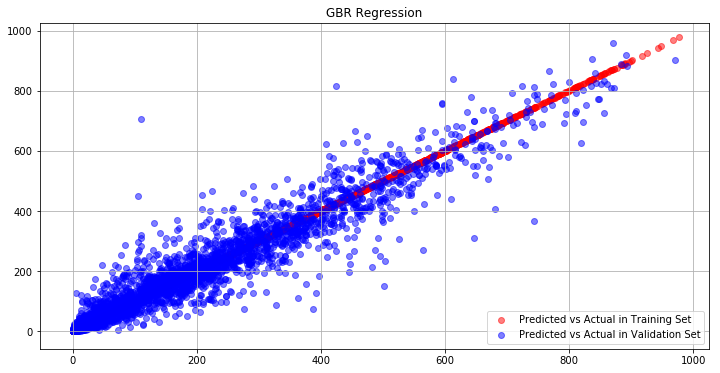

0.41249853984464419

In [100]:
gradientBoost(train_feature, train_target_count, valid_feature, valid_target_count)